# 1. Ucitati skup podataka koji je dodeljen vasem timu

In [24]:

import numpy as np
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import metrics

In [25]:
bank_marketing = pd.read_csv("../Data/master-data/bank-additional.csv", sep = ";")

categoric_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
numeric_columns = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
label_column = "y"
label_codes = {'yes':1, 'no':0}
label_codes_inverse = {1:'yes', 0:'no'}

# Map from yes/no to 1/0
bank_marketing[label_column] = bank_marketing[label_column].map(label_codes)

# Separate source data
label = bank_marketing[label_column]
categoric_data = bank_marketing.loc[:, categoric_columns].copy()
numeric_data = bank_marketing.loc[:, numeric_columns].copy()

# Replace 999 with -1 for column pdays, for experiment purpose i will try with -1 and 999 both combinations
numeric_data['pdays'] = numeric_data['pdays'].replace(999, -1) 


# 2. Prikazati deskriptivnu statistiku skupa podataka (tipovi podataka, rasponi vrednosti, nedostajuce vrednoti itd..)

### UKUPAN BROJ JEDINSTVENIH VREDNOSTI ZA NUMERICKE KOLONE

In [10]:
print(numeric_data.nunique())

age                67
duration          828
campaign           25
pdays              21
previous            7
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      27
euribor3m         235
nr.employed        12
dtype: int64


### UKUPAN BROJ JEDINSTVENIH VREDNOSTI ZA KATEGORICKE KOLONE

In [11]:
print(categoric_data.nunique())

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64


### UKUPAN BROJ JEDINSTVENIH VREDNOSTI ZA IZLAZNU ZAVISNU KOLONU

In [14]:
print(label.nunique())

2


### Prikaz tipova podataka za kategoricke kolone

In [16]:
categoric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 10 columns):
job            4119 non-null object
marital        4119 non-null object
education      4119 non-null object
default        4119 non-null object
housing        4119 non-null object
loan           4119 non-null object
contact        4119 non-null object
month          4119 non-null object
day_of_week    4119 non-null object
poutcome       4119 non-null object
dtypes: object(10)
memory usage: 321.9+ KB


### Prikaza tipova podataka za numericke kolone (i prilagodjavanje istih)

In [15]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 10 columns):
age               4119 non-null int64
duration          4116 non-null float64
campaign          4114 non-null float64
pdays             4119 non-null int64
previous          4117 non-null float64
emp.var.rate      4116 non-null float64
cons.price.idx    4117 non-null float64
cons.conf.idx     4117 non-null float64
euribor3m         4117 non-null float64
nr.employed       4118 non-null object
dtypes: float64(7), int64(2), object(1)
memory usage: 321.9+ KB


Kolona nr.employed ima pogresan tip podataka, pa moramo da proverimo o cemu se radi

In [17]:
numeric_data['nr.employed'].value_counts()

5228.1    1625
5099.1     822
5191       758
5195.8     392
5076.2     164
5017.5     104
4991.6      87
4963.6      83
5008.7      60
5023.5      21
5176.3       1
no           1
Name: nr.employed, dtype: int64

Primecujemo da postoji jedan zapis za pogresnim tipom podataka i ima vrednost 'no'. 
Zamenicemo taj zapis sa najucestalijom vrednoscu te kolone pomocu funkcije MODE, i konvertovacemo tip kolone na float64. 

In [26]:
nr_employeed_mode = numeric_data['nr.employed'].mode()
numeric_data[numeric_data['nr.employed'] == 'no'].index.values # row 780
numeric_data['nr.employed'] = numeric_data['nr.employed'].replace('no', float(nr_employeed_mode[0])) 
numeric_data = numeric_data.astype({'nr.employed': 'float64'})
numeric_data.dtypes

age                 int64
duration          float64
campaign          float64
pdays               int64
previous          float64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

In [27]:
pd.DataFrame(pd.value_counts(categoric_data.values.flatten())).T

,no,nonexistent,yes,cellular,married,telephone,may,university.degree,unknown,single,...,entrepreneur,success,unemployed,housemaid,student,oct,sep,mar,dec,illiterate
0,8503,3523,2841,2652,2509,1467,1378,1264,1230,1153,...,148,142,111,110,82,69,64,48,22,1


### Prikaz tipova podataka za kategoricke kolone

In [30]:
categoric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 10 columns):
job            4119 non-null object
marital        4119 non-null object
education      4119 non-null object
default        4119 non-null object
housing        4119 non-null object
loan           4119 non-null object
contact        4119 non-null object
month          4119 non-null object
day_of_week    4119 non-null object
poutcome       4119 non-null object
dtypes: object(10)
memory usage: 321.9+ KB


### Prikaz statistike za numericke podatke

In [34]:
numeric_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4116.000000,4114.000000,4119.000000,4117.000000,4116.000000,4117.000000,4117.000000,4117.000000,4118.000000
mean,40.113620,256.869048,2.534273,-0.733430,0.190430,0.084694,93.579540,-40.486358,4.858993,5166.498057
std,10.313362,254.763913,2.566673,1.532813,0.541904,1.563361,0.579442,4.639840,79.432456,73.669363
min,18.000000,0.000000,1.000000,-1.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,-1.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,-1.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.250000,3.000000,-1.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,21.000000,6.000000,1.400000,94.767000,1.266000,5099.100000,5228.100000


### Balans output varijable (da vidimo koliko su klase balansirane)

In [36]:
label.value_counts() / len(label)

0.0    0.890265
1.0    0.109493
Name: y, dtype: float64

### Provera nedostajucih vrednosti 

#### Kategoricki podaci i njihove nedostajuce vrednosti

In [44]:
print('==============   Any null value   ================')
print(categoric_data.isnull().any())
print('==============   Summation   ================')
print(categoric_data.isnull().sum())

==============   Any null value   ================
job            False
marital        False
education      False
default        False
housing        False
loan           False
contact        False
month          False
day_of_week    False
poutcome       False
dtype: bool
==============   Summation   ================
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
poutcome       0
dtype: int64


#### Numericki podaci i njihove nedostajuce vrednosti 

In [45]:
print('==============   Any null value   ================')
print(numeric_data.isnull().any())
print('==============   Summation   ================')
print(numeric_data.isnull().sum())

==============   Any null value   ================
age               False
duration           True
campaign           True
pdays             False
previous           True
emp.var.rate       True
cons.price.idx     True
cons.conf.idx      True
euribor3m          True
nr.employed        True
dtype: bool
==============   Summation   ================
age               0
duration          3
campaign          5
pdays             0
previous          2
emp.var.rate      3
cons.price.idx    2
cons.conf.idx     2
euribor3m         2
nr.employed       1
dtype: int64


#### Output kolona, odnosno zavisna varijabla, odnosno labela i njene nedostajuce vrednosti

In [46]:
print('==============   Summation   ================')
print(label.isnull().sum())


==============   Summation   ================
1


## Imputacija nedostajucih podataka

### Imputacija output klase, zavisnog atributa (pomocu mode() funkcije)

In [48]:
label = label.fillna(label.mode()[0])
print('==============   Summation   ================')
print(label.isnull().sum())

==============   Summation   ================
0


### Imputacija numerickih podataka za srednjim vrednostima atributa (pomocu funkcije mean())

In [49]:
numeric_data = numeric_data.fillna(numeric_data.mean())
print('==============   Summation   ================')
print(numeric_data.isnull().sum())

==============   Summation   ================
age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64


### Imputacija kategorickih podataka (kolone koje imaju vrednosti 'unknown')
Postoji nekoliko razlicith pristupa imputacije kategorickih podataka.
Neke od njih cu ovde nabrojati:

0. Brisanje svih redova koji sadze nedostajuce podatke
1. Ignorisati nedostajuce podatke
2. Napraviti model koji predvidja nedostajuce podatke
3. Tretirati nedostajuce podatke kao jos jednu kategoriju
4. Zameniti nedostajuce podatke sa najcescom vrednoscu pomocu funkcije mode()

#### Prvo cemo obrisati redove koji imaju sve NaN vrednosti

In [50]:
categoric_data = categoric_data.dropna(axis='index', how='all')
numeric_data = numeric_data.dropna(axis='index', how='all')

#### Provera procenata nedostajucih podataka

In [52]:
categorical_data_missing_values = ['marital', 'education', 'default', 'housing', 'loan']
data_len = len(categoric_data)

unknowns_categorical_data_percentages = pd.DataFrame([], columns = ['UnknownPercentage'], index = categorical_data_missing_values)

for column in categorical_data_missing_values:
	percentage_unknown = categoric_data[column].value_counts()['unknown'] / data_len
	unknowns_categorical_data_percentages.loc[column,:] = {'UnknownPercentage':percentage_unknown*100}
	
unknowns_categorical_data_percentages.head()

,UnknownPercentage
marital,0.267055
education,4.05438
default,19.495
housing,2.54916
loan,2.54916


##### Kolona 'marital' ima jako malo unknown vrednosti, biramo strategiju da zamenimo vrednosti sa najcescom vrednoscu

In [53]:
col_marital_mode = categoric_data['marital'].mode()
categoric_data['marital'] = categoric_data['marital'].replace('unknown', col_marital_mode.values[0])
categoric_data['marital'].value_counts()

married     2520
single      1153
divorced     446
Name: marital, dtype: int64

##### Kolona  'Default' ce zadrzati vrednosti 'unknown' 

##### Vrednosti 'unknown' kolona 'Housing' i 'Loan' ce biti zamenjene pomocu prediktivnog algoritma

In [56]:
print('Housing')
print(categoric_data['housing'].value_counts()) # possible values yes/no/unknown
print('Loan')
print(categoric_data['loan'].value_counts()) # possible values yes/no/unknown

Housing
yes    2280
no     1839
Name: housing, dtype: int64
Loan
no         3349
yes         665
unknown     105
Name: loan, dtype: int64


##### Kolona housing

In [55]:
indexes_not_missing_housing_values = categoric_data[categoric_data['housing'] != 'unknown'].index.values # get training data indexes
x_housing_train = numeric_data[numeric_data.index.isin(indexes_not_missing_housing_values)] # get features for training
x_housing_test = numeric_data[~numeric_data.index.isin(indexes_not_missing_housing_values)] # get features for prediction
Y_housing_train = categoric_data[categoric_data.index.isin(indexes_not_missing_housing_values)]['housing'].map(label_codes) # get labels for training (housing column)

# Fit housing imputation 
alg_housing_imputation = LogisticRegression(random_state=0).fit(x_housing_train, Y_housing_train)
# Predict housing imputation
housing_predicted_imputation = alg_housing_imputation.predict(x_housing_test)

# Create data frame with predicted values
index_missing_housing = categoric_data[categoric_data['housing'] == 'unknown'].index # get indexes of missing categorical rows
imputed_housing_missing_values = pd.DataFrame(data = housing_predicted_imputation, index = index_missing_housing, columns = ['housing']) # create data frame for new imputed values 
imputed_housing_missing_values['housing'] = imputed_housing_missing_values['housing'].map(label_codes_inverse) # map inverse to original data format yes/no

# Impute predicted data into original dataset
categoric_data.loc[imputed_housing_missing_values.index.values, 'housing'] = imputed_housing_missing_values.loc[:,'housing'] # impute to original data set

# Check imputation results
categoric_data['housing'].value_counts()

yes    2280
no     1839
Name: housing, dtype: int64

##### Kolona loan

In [57]:
# Loan imputation section
indexes_not_missing_loan_values = categoric_data[categoric_data['loan'] != 'unknown'].index.values
x_loan_train = numeric_data[numeric_data.index.isin(indexes_not_missing_loan_values)]
x_loan_test = numeric_data[~numeric_data.index.isin(indexes_not_missing_loan_values)]
Y_loan_train = categoric_data[categoric_data.index.isin(indexes_not_missing_loan_values)]['loan'].map(label_codes)

# Fit loan imputation
alg_loan_imputation = LogisticRegression(random_state=0).fit(x_loan_train, Y_loan_train)

# Predict loan imputation
loan_predicted_imputation = alg_loan_imputation.predict(x_loan_test);

# Create new data frame with predicted values
index_missing_loan = categoric_data[categoric_data['loan'] == 'unknown'].index 
imputed_loan_missing_values = pd.DataFrame(data = loan_predicted_imputation, index = index_missing_loan, columns = ['loan'])
imputed_loan_missing_values['loan'] = imputed_loan_missing_values['loan'].map(label_codes_inverse)

# Impute predicted data into original dataset
categoric_data.loc[imputed_loan_missing_values.index.values, 'loan'] = imputed_loan_missing_values.loc[:,'loan']

# Check imputation results 
categoric_data['loan'].value_counts()

no     3454
yes     665
Name: loan, dtype: int64

##### Kolona education tretiracemo podatke kao da klijent namerno nije hteo da da podatke i necemo menjati vrednosti MAR

##### Distribucija kolone AGE

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


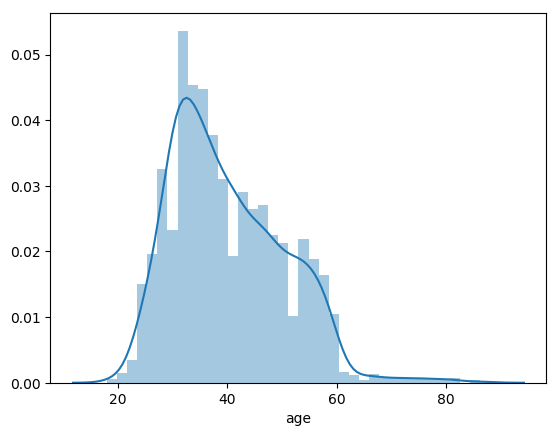

In [58]:
sns.distplot(numeric_data['age']);

##### Distribucija kolone duration

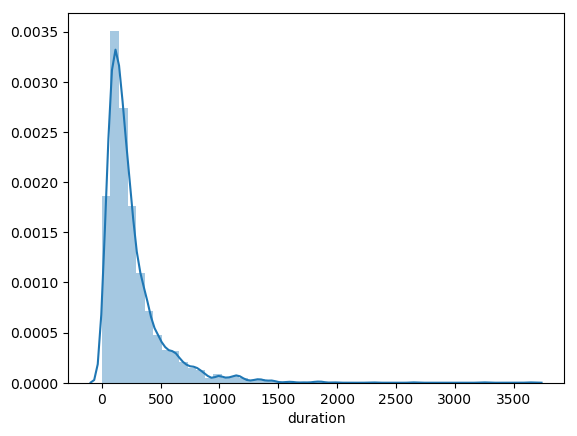

In [59]:
sns.distplot(numeric_data['duration']);

##### Distribucija kolone campaign

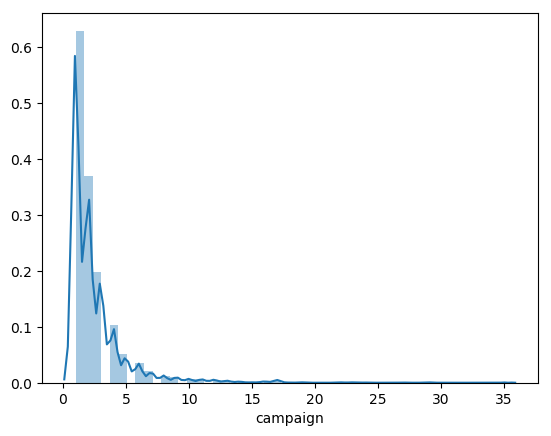

In [60]:
sns.distplot(numeric_data['campaign']);

##### Distribucija kolone emp.var.rate

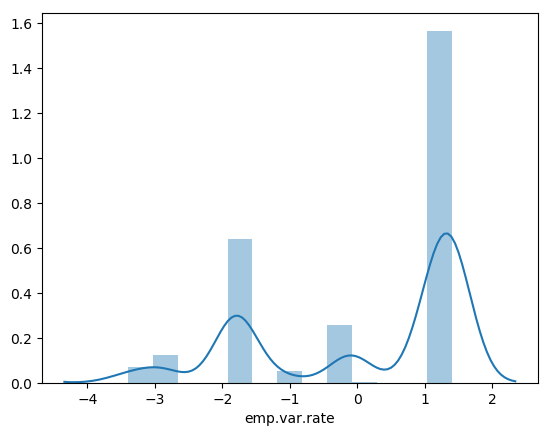

In [61]:
sns.distplot(numeric_data['emp.var.rate'])

# 3. Pripremiti skup podataka tako da bude pogodan za prediktivno modelovanje